In [1]:
file_path = "mystery.fa"

try:
    with open(file_path, "r") as file:
        # Read and print the first 10 lines
        for i in range(10):
            line = file.readline()
            print(line, end="")  # Print the line without adding an extra newline
except FileNotFoundError:
    print("File not found.")
except IOError:
    print("Error reading the file.")


>gb|KM061522.1|  [location=mitochondrion] [completeness=complete] [topology=circular] [organism=Canis lupus familiaris] [isolate=Cf_nk23] [sub_species=familiaris] [gcode=2] [haplotype=1] Canis lupus familiaris isolate Cf_nk23 mitochondrion, complete genome.
GTTAATGTAGCTTAATTAATAAAGCAAGGCACTGAAAATGCCAAGATGAGTCGCACGACT
CCATAAACATAAAGGTTTGGTCCTAGCCTTCCTATTAGTTTTTAGTAGACTTACACATGC
AAGCCTCCACGCCCCAGTGAGAATGCCCTTAAAATCACCAGTGATCTAAAGGAGCAGGTA
TCAAGCACACTCTTAAGTAGCTCATAACACCTTGCTAAGCCACACCCCCACGGGATACAG
CAGTGATAAAAATTAAGCCATAAACGAAAGTTTGACTAAGCCATACTAAATAGGGTTGGT
AAATTTCGTGCCAGCCACCGCGGTCATACGATTAACCCAAACTAATAGGCCTACGGCGTA
AAGCGTGTTCAAGATACTTTTACACTAAAGTTAAAACTTAACTAAGCCGTAAAAAGCTAC
AGTTATCATAAAATAAACCACGAAAGTGACTTTATAATAATCTGACTACACGATAGCTAA
GACCCAAACTGGGATTAGATACCCCACTATGCTTAGCCCTAAACATAGATAATTTTACAA


In [2]:
file_path = "dog_breeds.fa"

try:
    with open(file_path, "r") as file:
        # Read and print the first 10 lines
        for i in range(10):
            line = file.readline()
            print(line, end="")  # Print the line without adding an extra newline
except FileNotFoundError:
    print("File not found.")
except IOError:
    print("Error reading the file.")


>gb|CM023446.1| [location=mitochondrial] [completeness=complete] [topology=circular] [organism=Canis lupus familiaris] [isolate=Tasha] [sub_species=familiaris] [breed=boxer] [gcode=2] [sex=female] [tech=wgs] Canis lupus familiaris isolate Tasha breed boxer mitochondrion, complete sequence
GTTAATGTAGCTTAATTAATAAAGCAAGGCACTGAAAATGCCAAGATGAGTCGCACGACT
CCATAAACATAAAGGTTTGGTCCTAGCCTTCCTATTAGTTTTTAGTAGACTTACACATGC
AAGCCTCCACGCCCCAGTGAGAATGCCCTTAAAATCACCAGTGATCTAAAGGAGCAGGTA
TCAAGCACACTCTTAAGTAGCTCATAACACCTTGCTAAGCCACACCCCCACGGGATACAG
CAGTGATAAAAATTAAGCCATAAACGAAAGTTTGACTAAGCCATACTAAATAGGGTTGGT
AAATTTCGTGCCAGCCACCGCGGTCATACGATTAACCCAAACTAATAGGCCTACGGCGTA
AAGCGTGTTCAAGATACTTTTACACTAAAGTTAAAACTTAACTAAGCCGTAAAAAGCTAC
AGTTATCATAAAATAAACCACGAAAGTGACTTTATAATAATCTGACTACACGATAGCTAA
GACCCAAACTGGGATTAGATACCCCACTATGCTTAGCCCTAAACATAGATAATTTTACAA


In [5]:
from collections import Counter
import numpy as np
from scipy.stats import chi2_contingency

def read_fasta_file(file_path):
    """Read a FASTA file and return a dictionary of sequences."""
    sequences = {}
    current_header = None
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line.startswith('>'):
                current_header = line[1:]
                sequences[current_header] = ''
            else:
                sequences[current_header] += line
    return sequences

def calculate_probabilities(database_sequences):
    """Calculate probabilities of observing each base at each position in the database."""
    num_sequences = len(database_sequences)
    seq_length = len(list(database_sequences.values())[0])
    
    probabilities = {base: np.zeros(seq_length) for base in 'ACGT'}
    
    for sequence in database_sequences.values():
        for i, base in enumerate(sequence):
            if base in 'ACGT':
                probabilities[base][i] += 1
    
    for base, counts in probabilities.items():
        probabilities[base] = counts / num_sequences
    
    return probabilities

def calculate_p_value(test_sequence, database_sequences, probabilities):
    """Calculate the p-value for the test sequence against the database."""
    test_counts = Counter(test_sequence)
    expected_counts = {base: [prob * len(database_sequences) for prob in probs] for base, probs in probabilities.items()}
    
    contingency_table = [[test_counts[base], sum(test_counts.values()) - test_counts[base]] for base in 'ACGT']
    contingency_table += [[expected_counts[base][i], len(database_sequences) - expected_counts[base][i]] for i, base in enumerate('ACGT')]
    
    _, p_value, _, _ = chi2_contingency(contingency_table)
    return p_value

def find_closest_sequence(test_sequence, database_sequences):
    """Find the closest sequence in the database to the test sequence."""
    closest_sequence = None
    closest_difference = float('inf')
    for header, sequence in database_sequences.items():
        difference = calculate_difference(test_sequence, sequence)
        if difference < closest_difference:
            closest_sequence = header
            closest_difference = difference
    return closest_sequence, closest_difference

def calculate_difference(seq1, seq2):
    """Calculate the difference between two DNA sequences."""
    return sum(1 for base1, base2 in zip(seq1, seq2) if base1 != base2)

if __name__ == "__main__":
    # Read the database sequences
    database_file = "dog_breeds.fa"
    database_sequences = read_fasta_file(database_file)

    # Read the test sequence
    test_file = "mystery.fa"
    test_sequences = read_fasta_file(test_file)

    # Assume only one sequence in the test file for simplicity
    test_sequence = list(test_sequences.values())[0]

    # Calculate probabilities
    probabilities = calculate_probabilities(database_sequences)

    # Calculate p-value for each sequence in the database
    p_values = {}
    for header, sequence in database_sequences.items():
        p_values[header] = calculate_p_value(test_sequence, {header: sequence}, probabilities)

    # Find the sequence with the smallest p-value
    closest_sequence = min(p_values, key=p_values.get)
    closest_p_value = p_values[closest_sequence]

    # Calculate the difference between the test sequence and the closest sequence
    closest_difference = calculate_difference(test_sequence, database_sequences[closest_sequence])

    # Output the result
    output_file = "sequence_identification_results_and_probability_analysis.txt"
    with open(output_file, "w") as f:
        f.write("Closest Sequence: {}\n".format(closest_sequence))
        f.write("Difference: {}\n".format(closest_difference))
        f.write("P-value: {}\n".format(closest_p_value))

    print("Results saved to", output_file)


Results saved to sequence_identification_results_and_probability_analysis.txt


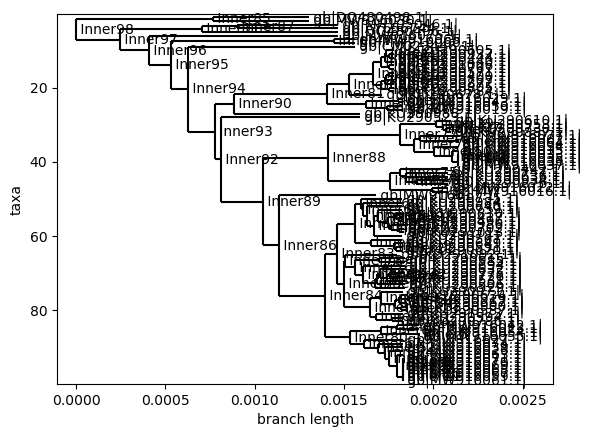

Closest sequence: gb|KU290786.1|
Distance: 0.7129291876556076


In [4]:
from Bio import AlignIO, Phylo
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

def construct_tree(alignment_file):
    # Read the alignment file
    alignment = AlignIO.read(alignment_file, "clustal")

    # Compute the distance matrix
    calculator = DistanceCalculator('identity')
    dm = calculator.get_distance(alignment)

    # Construct the tree using the UPGMA method
    constructor = DistanceTreeConstructor()
    tree = constructor.upgma(dm)

    return tree

def read_aligned_sequences(alignment_file):
    # Read the aligned sequences from the alignment file
    alignment = AlignIO.read(alignment_file, "clustal")
    return alignment

if __name__ == "__main__":
    # Specify the path to the aligned sequences file
    alignment_file = "aligned_sequences.aln"

    # Construct the phylogenetic tree
    tree = construct_tree(alignment_file)

    # Save the tree to a Newick file
    tree_output_file = "phylogenetic_tree.nwk"
    Phylo.write(tree, tree_output_file, "newick")

    # Visualize the tree
    Phylo.draw(tree)

    # Specify the path to the mystery sequence file
    mystery_sequence_file = "mystery.fa"

    # Read and align mystery sequence
    with open(mystery_sequence_file, "r") as f:
        mystery_sequence = Seq(f.read().strip())
        mystery_record = SeqRecord(mystery_sequence, id="Mystery")

    # Read the aligned sequences
    aligned_sequences = read_aligned_sequences(alignment_file)

    # Calculate distances between the mystery sequence and each sequence in the alignment
    distances = []
    for record in aligned_sequences:
        distance = sum(a != b for a, b in zip(record.seq, mystery_record.seq)) / len(mystery_record.seq)
        distances.append(distance)

    # Find the closest sequence in the alignment
    min_distance_index = distances.index(min(distances))
    closest_sequence = aligned_sequences[min_distance_index].id
    min_distance = min(distances)

    # Print the results
    print("Closest sequence:", closest_sequence)
    print("Distance:", min_distance)

    # Save the results to a file
    with open("output.txt", "w") as output_file:
        output_file.write(f"Closest sequence: {closest_sequence}\n")
        output_file.write(f"Distance: {min_distance}\n")
